In [2]:
import os
import re
import argparse
import random
import time
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
from math import exp
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.backends import cudnn
from glob import glob # https://www.pynote.net/archives/852
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
from torch.cuda.amp import autocast,GradScaler
from einops import rearrange, repeat
import torchvision
from utils import torchPSNR,torchSSIM,get_loader,get_loader2,get_fbp,getNPS_X,getNPS_Y
from timm.models.layers import trunc_normal_

In [3]:
# Input Projection
class InputProj(nn.Module):
    def __init__(self, in_channel=3, out_channel=64, kernel_size=3, stride=1, norm_layer=None,act_layer=nn.LeakyReLU,isPadding=False):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=kernel_size//2 if isPadding == True else 0),
            act_layer(inplace=True)
        )
        if norm_layer is not None:
            self.norm = norm_layer(out_channel)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2).contiguous()  # B H*W C
        if self.norm is not None:
            x = self.norm(x)
        return x
# Output Projection
class OutputProj(nn.Module):
    def __init__(self, in_channel=64, out_channel=3, kernel_size=3, stride=1, norm_layer=None,act_layer=None,isPadding=False):
        super().__init__()
        self.proj = nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=kernel_size//2 if isPadding == True else 0),
        )
        if act_layer is not None:
            self.proj.add_module(act_layer(inplace=True))
        if norm_layer is not None:
            self.norm = norm_layer(out_channel)
        else:
            self.norm = None

    def forward(self, x):
        B, L, C = x.shape
        H = int(math.sqrt(L))
        W = int(math.sqrt(L))
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.proj(x)
        if self.norm is not None:
            x = self.norm(x)
        return x
#########################################
######## Embedding for q,k,v ########
# LinearProjection(dim,num_heads,dim//num_heads,bias=qkv_bias)
class LinearProjection(nn.Module):
    def __init__(self, dim = 512, heads = 8, dim_head = 64, dropout = 0., bias=True):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.to_q = nn.Linear(dim, inner_dim, bias = bias)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias = bias)

    def forward(self, x, attn_kv=None):
        B_, N, C = x.shape
        attn_kv = x if attn_kv is None else attn_kv
        q = self.to_q(x).reshape(B_, N, 1, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        kv = self.to_kv(attn_kv).reshape(B_, N, 2, self.heads, C // self.heads).permute(2, 0, 3, 1, 4) 
        q = q[0]
        k, v = kv[0], kv[1] 
        return q,k,v
class convBlock(nn.Module):
    def __init__(self, dim=32, hidden_dim=128, act_layer=nn.GELU,drop = 0.):
        super().__init__()
        self.linear1 = nn.Sequential(nn.Linear(dim, hidden_dim),
                                act_layer())
        self.dwconv = nn.Sequential(nn.Conv2d(hidden_dim,hidden_dim,groups=hidden_dim,kernel_size=3,stride=1,padding=1),
                        act_layer())
        self.linear2 = nn.Sequential(nn.Linear(hidden_dim, dim))
    def forward(self, x):
        bs, hw, c = x.size()
        hh = int(math.sqrt(hw))
        x = self.linear1(x)
        x = rearrange(x, ' b (h w) (c) -> b c h w ', h = hh, w = hh)
        x = self.dwconv(x)
        x = rearrange(x, ' b c h w -> b (h w) c', h = hh, w = hh)
        x = self.linear2(x)
        return x
########### Patch-based self-attention #############
class Attention(nn.Module):
    def __init__(self, dim, patch_size,num_heads, qkv_bias=True, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.patch_size = patch_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * patch_size[0] - 1) * (2 * patch_size[1] - 1), num_heads)) 

        coords_h = torch.arange(self.patch_size[0]) 
        coords_w = torch.arange(self.patch_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  
        coords_flatten = torch.flatten(coords, 1) 
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  
        relative_coords = relative_coords.permute(1, 2, 0).contiguous() 
        relative_coords[:, :, 0] += self.patch_size[0] - 1 
        relative_coords[:, :, 1] += self.patch_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.patch_size[1] - 1
        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = LinearProjection(dim,num_heads,dim//num_heads,bias=qkv_bias)
        
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, attn_kv=None, mask=None):
        B_, N, C = x.shape
        q, k, v = self.qkv(x,attn_kv)

        q = q * self.scale
        
        attn = (q @ k.transpose(-2, -1))
#         print(attn.shape)
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.patch_size[0] * self.patch_size[1], self.patch_size[0] * self.patch_size[1], -1)  
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous() 
#         print(relative_position_bias.shape)
        ratio = attn.size(-1)//relative_position_bias.size(-1)
        relative_position_bias = repeat(relative_position_bias, 'nH l c -> nH l (c d)', d = ratio)
#         print(relative_position_bias.shape)
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            mask = repeat(mask, 'nW m n -> nW m (n d)',d = ratio)
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N*ratio) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N*ratio)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
def patch_partition(x, patch_size, dilation_rate=1):
    B, H, W, C = x.shape
    x = x.view(B, H // patch_size, patch_size, W // patch_size, patch_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, patch_size, patch_size, C)
    return windows

def patch_reverse(patches, patch_size, H, W, dilation_rate=1):
    B = int(patches.shape[0] / (H * W / patch_size / patch_size))
    x = patches.view(B, H // patch_size, W // patch_size, patch_size, patch_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, patch_size=8, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., 
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.patch_size = patch_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        assert 0 <= self.shift_size < self.patch_size, "shift_size must in 0-patch_size"

        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, patch_size=[self.patch_size,self.patch_size], num_heads=num_heads,
            qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)

        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = convBlock(dim,mlp_hidden_dim,act_layer=act_layer, drop=drop)

    def forward(self, x):
        B, L, C = x.shape
        H = int(math.sqrt(L))
        W = int(math.sqrt(L))
        assert self.patch_size <= H, "patch_size:{},H:{}".format(self.patch_size,H)
        
        attn_mask = None

        ## shift mask
        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            shift_mask = torch.zeros((1, H, W, 1)).type_as(x)
            h_slices = (slice(0, -self.patch_size),
                        slice(-self.patch_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.patch_size),
                        slice(-self.patch_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    shift_mask[:, h, w, :] = cnt
                    cnt += 1
            shift_mask_patch = patch_partition(shift_mask, self.patch_size)
            shift_mask_patch = shift_mask_patch.view(-1, self.patch_size * self.patch_size) 
            shift_attn_mask = shift_mask_patch.unsqueeze(1) - shift_mask_patch.unsqueeze(2)
            attn_mask = attn_mask or shift_attn_mask
            attn_mask = attn_mask.masked_fill(shift_attn_mask != 0, float(-100.0))
            
        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        x_p = patch_partition(shifted_x, self.patch_size)  
        x_p = x_p.view(-1, self.patch_size * self.patch_size, C)  

        # W-MSA/SW-MSA
        attn_p = self.attn(x_p, mask=attn_mask) 

        # merge windows
        attn_p = attn_p.view(-1, self.patch_size, self.patch_size, C)
        shifted_x = patch_reverse(attn_p, self.patch_size, H, W)  

        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + x
        x = x + self.mlp(self.norm2(x))
        del attn_mask
        return x
class DenseBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(DenseBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=1),
            nn.GELU()
        )

    def forward(self, x):
        B, L, C = x.shape
        H = int(math.sqrt(L))
        W = int(math.sqrt(L))
        x = x.transpose(1, 2).contiguous().view(B, C, H, W)
        out = self.conv(x).flatten(2).transpose(1,2).contiguous()  # B H*W C
        return out
    
class BasicBlock(nn.Module):
    def __init__(self, input_chn,dim, depth, num_heads, patch_size,
                 mlp_ratio=4., qkv_bias=True,  drop=0., attn_drop=0., norm_layer=nn.LayerNorm):
        super(BasicBlock,self).__init__()

        # build blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(dim=dim,
                                 num_heads=num_heads, patch_size=patch_size,
                                 shift_size=0 if (i % 2 == 0) else patch_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias,
                                 drop=drop, attn_drop=attn_drop,
                                 norm_layer=norm_layer)
            for i in range(depth)])
        self.cat2 = DenseBlock(in_channel=dim*2, out_channel=dim)
    def forward(self, x):
        xs = []
        for blk in self.blocks:
            xs.append(blk(x))
        xs = self.cat2(torch.cat([xs[0],xs[1]],dim=-1))
        return xs
class sinogram_domain(nn.Module):
    def __init__(self,input_channels,embed_dim=64):
        super().__init__()
        layer = []
        self.input_proj = InputProj(in_channel=input_channels, out_channel=embed_dim, 
                                    kernel_size=4, stride=4, act_layer=nn.LeakyReLU)
        self.output_proj = OutputProj(in_channel=embed_dim, out_channel=input_channels, kernel_size=4, stride=4)
        self.num_layers = 5
        for i in range(self.num_layers):
            layer.append(BasicBlock(input_chn=embed_dim,
                        dim=embed_dim, 
                        depth=2,
                        num_heads=16,
                        patch_size=8,
                        mlp_ratio=4.,
                        qkv_bias=True,
                        drop=0.2, attn_drop=0.2))
        self.net = nn.Sequential(*layer)
    def forward(self,X):
        for i,layer in enumerate(self.net):
            if i == 0 :
                temp1 = X
                X = self.input_proj(X)
            elif i == 1 :
                temp2 = X
            elif i == self.num_layers -1 :
                X = X + temp2 
            else:
                temp2 = X + temp2
            X = layer(X)
        return self.output_proj(X) + temp1
class image_domain(nn.Module):
    def __init__(self,input_channels,embed_dim=64):
        super().__init__()
        layer = []
        self.input_proj = InputProj(in_channel=input_channels, out_channel=embed_dim, 
                                    kernel_size=4, stride=4, act_layer=nn.LeakyReLU)
        self.output_proj = OutputProj(in_channel=embed_dim, out_channel=input_channels, kernel_size=4, stride=4)
        self.num_layers = 7
        for i in range(self.num_layers):
            layer.append(BasicBlock(input_chn=embed_dim,
                        dim=embed_dim, 
                        depth=2,
                        num_heads=16,
                        patch_size=8,
                        mlp_ratio=4.,
                        qkv_bias=True,
                        drop=0.2, attn_drop=0.2))
        self.net = nn.Sequential(*layer)
    def forward(self,X):
        for i,layer in enumerate(self.net):
            if i == 0 :
                temp1 = X
                X = self.input_proj(X)
            elif i == 1 :
                temp2 = X
            elif i == self.num_layers -1 :
                X = X + temp2 
            else:
                temp2 = X + temp2
            X = layer(X)
        return self.output_proj(X) + temp1
#dataloader
class ct_dataset(Dataset):
    def __init__(self,data_path,patientsID):
        super().__init__()
        input_path = sorted(glob(os.path.join(data_path,'*_sparse.npy')))
        target_path = sorted(glob(os.path.join(data_path,'*_full.npy')))
        self.input_ = [f for f in input_path if re.search(r"(C|N|L)\d{3}", f)[0] in patientsID]
        self.target_ = [f for f in target_path if re.search(r"(C|N|L)\d{3}", f)[0] in patientsID]
        
    def __len__(self):
        return len(self.input_)
    def __getitem__(self, idx):

        input_img, target_img = self.input_[idx], self.target_[idx]
        input_img, target_img = np.load(input_img),np.load(target_img)
        input_img,target_img = torch.Tensor(input_img),torch.Tensor(target_img)
        return input_img.unsqueeze(0),target_img.unsqueeze(0)

In [4]:
a = sinogram_domain(1,embed_dim=32)
device = torch.device('cuda')
a = a.to(device)
# print(a)
X = torch.rand(size=(1,1,128,128),dtype=torch.float32)
X = X.to(device)

# test2

In [7]:
def test(net,test_iter,full_view_size,num_gpus):
    
    devices = [torch.device('cuda:'+str(i)) for i in range(num_gpus)]
    net = nn.DataParallel(net,device_ids=devices).to(devices[0])
    sd_net = sinogram_domain(1,embed_dim=32)
    sd_net.load_state_dict(torch.load('./result_model/sinogram_domain_64_2.pkl'),strict=True)
    sd_net = nn.DataParallel(sd_net,device_ids=devices).to(devices[0])
    # upsample = nn.Upsample(size=(full_view_size,512), mode='bilinear',align_corners=False)
    net.eval()
    sd_net.eval()
    test_psnr,test_ssim = [],[]
    loss = nn.MSELoss()
    test_loss = []
    for i,(input_,target_) in enumerate(test_iter):
        # input_ = upsample(input_)
        input_,target_ = input_.to(devices[0],dtype=torch.float),target_.to(devices[0],dtype=torch.float)
        with torch.no_grad():      
            input_ = sd_net(input_)
            input_,target_ = get_fbp(input_,n_angles=full_view_size),get_fbp(target_,n_angles=full_view_size)
            pred_ = net(input_)
            # pred_ = input_    # no image_domain
        psnr = torchPSNR(pred_,target_) 
        ssim = torchSSIM(pred_,target_) 
        test_psnr.append(psnr)
        test_ssim.append(ssim)
        test_loss.append(loss(pred_,target_))
    test_psnr_mean,test_psnr_std  = torch.stack(test_psnr).mean().item(), torch.stack(test_psnr).std().item()
    test_ssim_mean,test_ssim_std  = torch.stack(test_ssim).mean().item(), torch.stack(test_ssim).std().item()
    test_loss_mean,test_loss_std  = torch.stack(test_loss).mean().item(), torch.stack(test_loss).std().item()
    print('\t test psnr mean: {:.4f},test psnr std: {:.4f}\n\t test ssim mean: {:.4f},test ssim std: {:.4f}\n'.format(test_psnr_mean,test_psnr_std,test_ssim_mean,test_ssim_std))
    print('\t test loss mean: {:.4f},test loss std: {:.4f}'.format(test_loss_mean*100,test_loss_std*100))

In [11]:
batch_size = 4
full_view_size,num_gpus,num_workers= 512,2,8
data_path,patientsID_path= './2020_mayo_sinogram_img','./2020_mayo_patientsID'
save_name ='./result_model/image_domain_64.pkl'
_,_,test_iter = get_loader(data_path=data_path,patientsID_path=patientsID_path,batch_size=batch_size,num_workers=num_workers)
net = image_domain(1,embed_dim=32)
net.load_state_dict(torch.load(save_name),strict=True)
test(net,test_iter,full_view_size,num_gpus)
torch.cuda.empty_cache()

train_dataset numbers:20800
valid_dataset numbers:2586
test_dataset numbers:2522

	 test psnr mean: 34.8335,test psnr std: 1.8713
	 test ssim mean: 0.8731,test ssim std: 0.0385

	 test loss mean: 0.0362,test loss std: 0.0126


In [9]:
batch_size = 4
full_view_size,num_gpus,num_workers= 512,2,8
data_path,patientsID_path= './2020_mayo_sinogram_img_64','./2020_mayo_patientsID'
save_name ='./result_model/image_domain_64.pkl'
_,_,test_iter = get_loader(data_path=data_path,patientsID_path=patientsID_path,batch_size=batch_size,num_workers=num_workers)
net = image_domain(1,embed_dim=32)
net.load_state_dict(torch.load(save_name),strict=True)
test(net,test_iter,full_view_size,num_gpus)
torch.cuda.empty_cache()

train_dataset numbers:20800
valid_dataset numbers:2586
test_dataset numbers:2522

	 test psnr mean: 29.6453,test psnr std: 0.9910
	 test ssim mean: 0.7590,test ssim std: 0.0495

	 test loss mean: 0.1129,test loss std: 0.0236


# Qualitative Comparisons

## 64views

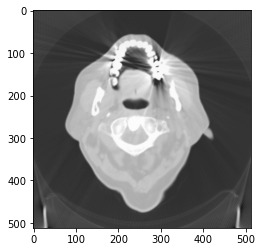

In [25]:
def rRMSE(x,y):
    return np.linalg.norm(x-y)/np.linalg.norm(y)*100
patient,number= 'N176','1'
origin = torch.Tensor(np.load('./2020_mayo_sinogram_img/{}_{}_full.npy'.format(patient,number))).unsqueeze(0).unsqueeze(0).to('cuda:0')
origin = get_fbp(origin,n_angles=512)
origin = origin.to('cpu').squeeze(0).squeeze(0).numpy()
plt.imshow(origin,cmap='gray')
plt.show()

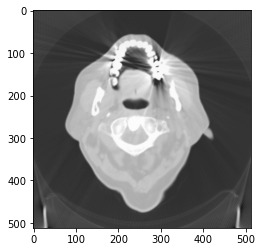

In [73]:
origin = torch.Tensor(np.load('./2020_mayo_sinogram_img/{}_{}_full.npy'.format(patient,number))).unsqueeze(0).unsqueeze(0).to('cuda:0')
origin = get_fbp(origin,n_angles=512)
origin = origin.to('cpu').squeeze(0).squeeze(0).numpy()
plt.imshow(origin,cmap='gray')
plt.show()

In [74]:
sinogram = torch.Tensor(np.load('./2020_mayo_sinogram_img_64/{}_64_{}_sparse.npy'.format(patient,number))).unsqueeze(0).unsqueeze(0).to('cuda:0')
sd_net = sinogram_domain(1,embed_dim=32)
sd_net.load_state_dict(torch.load('./result_model/sinogram_domain_64_2.pkl'),strict=True)
sd_net = sd_net.to('cuda:0')
id_net = image_domain(1,embed_dim=32)
id_net.load_state_dict(torch.load('./result_model/image_domain_64.pkl'),strict=True)
id_net = id_net.to('cuda:0')
sd_net.eval()
id_net.eval()
upsample = nn.Upsample(size=(512,512), mode='bilinear',align_corners=False)
with torch.no_grad():   
    sinogram = upsample(sinogram)
    sinogram = sd_net(sinogram)
    sinogram = get_fbp(sinogram,n_angles=512)
    sinogram = id_net(sinogram)
sinogram = sinogram.to('cpu').squeeze(0).squeeze(0).numpy()

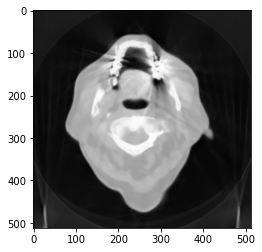

PSNR:31.073741912841797
SSIM:0.8280479907989502
RSME*100:0.0807400494813919


(None, 6.774748116731644, 0.32757896, -0.49882978)

In [75]:
plt.imsave('fig4/DDPTransformer_n_64.jpeg', sinogram,cmap='gray')
plt.imshow(sinogram,cmap='gray')
plt.show()
print("PSNR:{}".format(torchPSNR(torch.Tensor(sinogram),torch.Tensor(origin))))
print("SSIM:{}".format(torchSSIM(torch.Tensor(sinogram),torch.Tensor(origin))))
loss = nn.MSELoss()
print("RSME*100:{}".format(100*loss(torch.Tensor(sinogram),torch.Tensor(origin))))
plt.imsave('roi/DDPTransformer_n_64.jpeg',sinogram[240:240+100,240:240+100],cmap='gray')
residual = origin-sinogram
plt.imsave('residual_image/DDPTransformer_n_64.jpeg',residual,cmap='gray')
plt.imsave('roi_residual_image/DDPTransformer_n_64.jpeg',residual[240:240+100,240:240+100],cmap='gray')
plt.show(),rRMSE(sinogram,origin),residual.max(),residual.min()

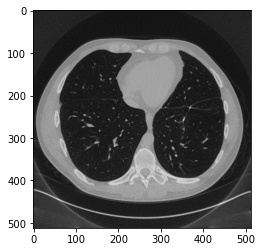

In [76]:
patient,number= 'C166','130'
origin = torch.Tensor(np.load('./2020_mayo_sinogram_img/{}_{}_full.npy'.format(patient,number))).unsqueeze(0).unsqueeze(0).to('cuda:0')
origin = get_fbp(origin,n_angles=512)
origin = origin.to('cpu').squeeze(0).squeeze(0).numpy()
plt.imshow(origin,cmap='gray')
plt.show()

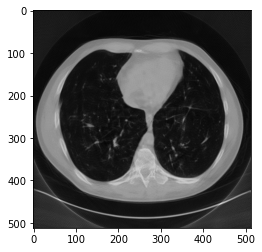

PSNR:27.81167221069336
SSIM:0.6977308988571167
RSME*100:0.16704121232032776


(None, 10.798881947994232)

In [77]:
sinogram = torch.Tensor(np.load('./2020_mayo_sinogram_img_64/C166_64_130_sparse.npy')).unsqueeze(0).unsqueeze(0).to('cuda:0')
sd_net = sinogram_domain(1,embed_dim=32)
sd_net.load_state_dict(torch.load('./result_model/sinogram_domain_64_2.pkl'),strict=True)
sd_net = sd_net.to('cuda:0')
id_net = image_domain(1,embed_dim=32)
id_net.load_state_dict(torch.load('./result_model/image_domain_64.pkl'),strict=True)
id_net = id_net.to('cuda:0')
sd_net.eval()
id_net.eval()
upsample = nn.Upsample(size=(512,512), mode='bilinear',align_corners=False)
with torch.no_grad():      
    sinogram = upsample(sinogram)
    sinogram = sd_net(sinogram)
    sinogram = get_fbp(sinogram,n_angles=512)
    sinogram = id_net(sinogram)
sinogram = sinogram.to('cpu').squeeze(0).squeeze(0).numpy()
plt.imsave('fig4/DDPTransformer_c_64.jpeg', sinogram,cmap='gray')
plt.imshow(sinogram,cmap='gray')
plt.show()
print("PSNR:{}".format(torchPSNR(torch.Tensor(sinogram),torch.Tensor(origin))))
print("SSIM:{}".format(torchSSIM(torch.Tensor(sinogram),torch.Tensor(origin))))
loss = nn.MSELoss()
print("RSME*100:{}".format(100*loss(torch.Tensor(sinogram),torch.Tensor(origin))))
plt.imsave('roi/DDPTransformer_c_64.jpeg',sinogram[320:320+100,215:215+100],cmap='gray')
residual = origin-sinogram
plt.imsave('residual_image/DDPTransformer_c_64.jpeg',residual,cmap='gray')
plt.imsave('roi_residual_image/DDPTransformer_c_64.jpeg',residual[320:320+100,215:215+100],cmap='gray')
plt.show(),rRMSE(sinogram,origin)

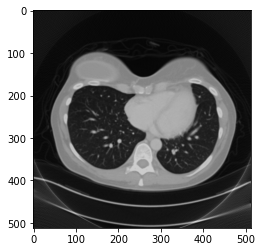

In [78]:
patient,number= 'L209','92'
origin = torch.Tensor(np.load('./2020_mayo_sinogram_img/{}_{}_full.npy'.format(patient,number))).unsqueeze(0).unsqueeze(0).to('cuda:0')
origin = get_fbp(origin,n_angles=512)
origin = origin.to('cpu').squeeze(0).squeeze(0).numpy()
plt.imshow(origin,cmap='gray')
plt.show()

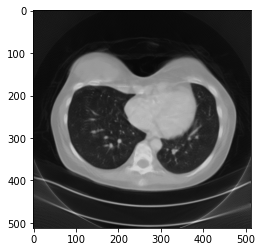

PSNR:30.692569732666016
SSIM:0.8477234244346619
RSME*100:0.08592023700475693


(None, 7.539320737123489)

In [79]:
sinogram = torch.Tensor(np.load('./2020_mayo_sinogram_img_64/L209_64_92_sparse.npy')).unsqueeze(0).unsqueeze(0).to('cuda:0')
sd_net = sinogram_domain(1,embed_dim=32)
sd_net.load_state_dict(torch.load('./result_model/sinogram_domain_64_2.pkl'),strict=True)
sd_net = sd_net.to('cuda:0')
id_net = image_domain(1,embed_dim=32)
id_net.load_state_dict(torch.load('./result_model/image_domain_64.pkl'),strict=True)
id_net = id_net.to('cuda:0')
sd_net.eval()
id_net.eval()
upsample = nn.Upsample(size=(512,512), mode='bilinear',align_corners=False)
with torch.no_grad():      
    sinogram = upsample(sinogram)
    sinogram = sd_net(sinogram)
    sinogram = get_fbp(sinogram,n_angles=512)
    sinogram = id_net(sinogram)
sinogram = sinogram.to('cpu').squeeze(0).squeeze(0).numpy()
plt.imsave('fig4/DDPTransformer_l_64.jpeg', sinogram,cmap='gray')
plt.imshow(sinogram,cmap='gray')
plt.show()
print("PSNR:{}".format(torchPSNR(torch.Tensor(sinogram),torch.Tensor(origin))))
print("SSIM:{}".format(torchSSIM(torch.Tensor(sinogram),torch.Tensor(origin))))
loss = nn.MSELoss()
print("RSME*100:{}".format(100*loss(torch.Tensor(sinogram),torch.Tensor(origin))))
plt.imsave('roi/DDPTransformer_l_64.jpeg',sinogram[230:230+100,110:110+100],cmap='gray')
residual = origin-sinogram
plt.imsave('residual_image/DDPTransformer_l_64.jpeg',residual,cmap='gray')
plt.imsave('roi_residual_image/DDPTransformer_l_64.jpeg',residual[230:230+100,110:110+100],cmap='gray')
plt.show(),rRMSE(sinogram,origin)

## 128views

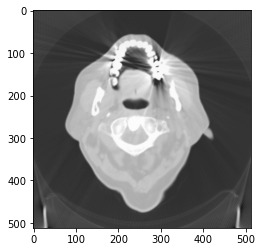

In [80]:
patient,number= 'N176','1'
origin = torch.Tensor(np.load('./2020_mayo_sinogram_img/{}_{}_full.npy'.format(patient,number))).unsqueeze(0).unsqueeze(0).to('cuda:0')
origin = get_fbp(origin,n_angles=512)
origin = origin.to('cpu').squeeze(0).squeeze(0).numpy()
plt.imshow(origin,cmap='gray')
plt.show()

In [81]:
sinogram = torch.Tensor(np.load('./2020_mayo_sinogram_img/{}_{}_sparse.npy'.format(patient,number))).unsqueeze(0).unsqueeze(0).to('cuda:0')
sd_net = sinogram_domain(1,embed_dim=32)
sd_net.load_state_dict(torch.load('./result_model/sinogram_domain_64_2.pkl'),strict=True)
sd_net = sd_net.to('cuda:0')
id_net = image_domain(1,embed_dim=32)
id_net.load_state_dict(torch.load('./result_model/image_domain_64.pkl'),strict=True)
id_net = id_net.to('cuda:0')
sd_net.eval()
id_net.eval()
upsample = nn.Upsample(size=(512,512), mode='bilinear',align_corners=False)
with torch.no_grad():      
    sinogram = upsample(sinogram)
    sinogram = sd_net(sinogram)
    sinogram = get_fbp(sinogram,n_angles=512)
    sinogram = id_net(sinogram)
sinogram = sinogram.to('cpu').squeeze(0).squeeze(0).numpy()

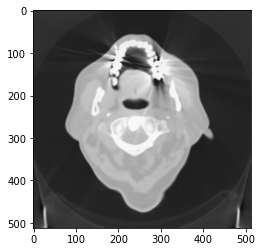

PSNR:39.91780090332031
SSIM:0.9476758241653442
RSME*100:0.01065827812999487


(None, 2.461456321179867)

In [82]:
plt.imsave('fig5/DDPTransformer_n_128.jpeg', sinogram,cmap='gray')
plt.imshow(sinogram,cmap='gray')
plt.show()
print("PSNR:{}".format(torchPSNR(torch.Tensor(sinogram),torch.Tensor(origin))))
print("SSIM:{}".format(torchSSIM(torch.Tensor(sinogram),torch.Tensor(origin))))
loss = nn.MSELoss()
print("RSME*100:{}".format(100*loss(torch.Tensor(sinogram),torch.Tensor(origin))))
plt.imsave('roi/DDPTransformer_n_128.jpeg',sinogram[240:240+100,240:240+100],cmap='gray')
residual = origin-sinogram
plt.imsave('residual_image/DDPTransformer_n_128.jpeg',residual,cmap='gray')
plt.imsave('roi_residual_image/DDPTransformer_n_128.jpeg',residual[240:240+100,240:240+100],cmap='gray')
plt.show(),rRMSE(sinogram,origin)

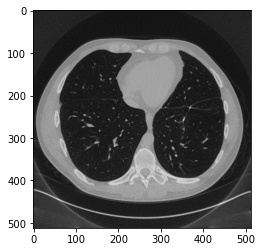

In [83]:
patient,number= 'C166','130'
origin = torch.Tensor(np.load('./2020_mayo_sinogram_img/{}_{}_full.npy'.format(patient,number))).unsqueeze(0).unsqueeze(0).to('cuda:0')
origin = get_fbp(origin,n_angles=512)
origin = origin.to('cpu').squeeze(0).squeeze(0).numpy()
plt.imshow(origin,cmap='gray')
plt.show()

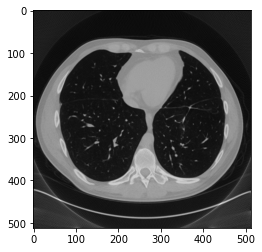

PSNR:33.05979537963867
SSIM:0.8396205306053162
RSME*100:0.050295114517211914


(None, 5.925566703081131)

In [84]:
sinogram = torch.Tensor(np.load('./2020_mayo_sinogram_img/C166_130_sparse.npy')).unsqueeze(0).unsqueeze(0).to('cuda:0')
sd_net = sinogram_domain(1,embed_dim=32)
sd_net.load_state_dict(torch.load('./result_model/sinogram_domain_64_2.pkl'),strict=True)
sd_net = sd_net.to('cuda:0')
id_net = image_domain(1,embed_dim=32)
id_net.load_state_dict(torch.load('./result_model/image_domain_64.pkl'),strict=True)
id_net = id_net.to('cuda:0')
sd_net.eval()
id_net.eval()
upsample = nn.Upsample(size=(512,512), mode='bilinear',align_corners=False)
with torch.no_grad():      
    sinogram = upsample(sinogram)
    sinogram = sd_net(sinogram)
    sinogram = get_fbp(sinogram,n_angles=512)
    sinogram = id_net(sinogram)
sinogram = sinogram.to('cpu').squeeze(0).squeeze(0).numpy()
plt.imsave('fig5/DDPTransformer_c_128.jpeg', sinogram,cmap='gray')
plt.imshow(sinogram,cmap='gray')
plt.show()
print("PSNR:{}".format(torchPSNR(torch.Tensor(sinogram),torch.Tensor(origin))))
print("SSIM:{}".format(torchSSIM(torch.Tensor(sinogram),torch.Tensor(origin))))
loss = nn.MSELoss()
print("RSME*100:{}".format(100*loss(torch.Tensor(sinogram),torch.Tensor(origin))))
plt.imsave('roi/DDPTransformer_c_128.jpeg',sinogram[320:320+100,215:215+100],cmap='gray')
residual = origin-sinogram
plt.imsave('residual_image/DDPTransformer_c_128.jpeg',residual,cmap='gray')
plt.imsave('roi_residual_image/DDPTransformer_c_128.jpeg',residual[320:320+100,215:215+100],cmap='gray')
plt.show(),rRMSE(sinogram,origin)

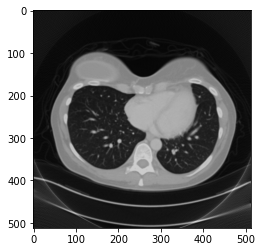

In [85]:
patient,number= 'L209','92'
origin = torch.Tensor(np.load('./2020_mayo_sinogram_img/{}_{}_full.npy'.format(patient,number))).unsqueeze(0).unsqueeze(0).to('cuda:0')
origin = get_fbp(origin,n_angles=512)
origin = origin.to('cpu').squeeze(0).squeeze(0).numpy()
plt.imshow(origin,cmap='gray')
plt.show()

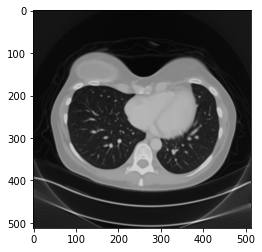

PSNR:39.513973236083984
SSIM:0.95551598072052
RSME*100:0.011365702375769615


(None, 2.7420956641435623)

In [86]:
sinogram = torch.Tensor(np.load('./2020_mayo_sinogram_img/L209_92_sparse.npy')).unsqueeze(0).unsqueeze(0).to('cuda:0')
sd_net = sinogram_domain(1,embed_dim=32)
sd_net.load_state_dict(torch.load('./result_model/sinogram_domain_64_2.pkl'),strict=True)
sd_net = sd_net.to('cuda:0')
id_net = image_domain(1,embed_dim=32)
id_net.load_state_dict(torch.load('./result_model/image_domain_64.pkl'),strict=True)
id_net = id_net.to('cuda:0')
sd_net.eval()
id_net.eval()
upsample = nn.Upsample(size=(512,512), mode='bilinear',align_corners=False)
with torch.no_grad():      
    sinogram = upsample(sinogram)
    sinogram = sd_net(sinogram)
    sinogram = get_fbp(sinogram,n_angles=512)
    sinogram = id_net(sinogram)
sinogram = sinogram.to('cpu').squeeze(0).squeeze(0).numpy()
plt.imsave('fig5/DDPTransformer_l_128.jpeg', sinogram,cmap='gray')
plt.imshow(sinogram,cmap='gray')
plt.show()
print("PSNR:{}".format(torchPSNR(torch.Tensor(sinogram),torch.Tensor(origin))))
print("SSIM:{}".format(torchSSIM(torch.Tensor(sinogram),torch.Tensor(origin))))
loss = nn.MSELoss()
print("RSME*100:{}".format(100*loss(torch.Tensor(sinogram),torch.Tensor(origin))))
plt.imsave('roi/DDPTransformer_l_128.jpeg',sinogram[230:230+100,110:110+100],cmap='gray')
residual = origin-sinogram
plt.imsave('residual_image/DDPTransformer_l_128.jpeg',residual,cmap='gray')
plt.imsave('roi_residual_image/DDPTransformer_l_128.jpeg',residual[230:230+100,110:110+100],cmap='gray')
plt.show(),rRMSE(sinogram,origin)

# 2016AAPM

In [87]:
def test(net,test_iter,full_view_size,num_gpus):
    
    devices = [torch.device('cuda:'+str(i)) for i in range(num_gpus)]
    net = nn.DataParallel(net,device_ids=devices).to(devices[0])
    sd_net = sinogram_domain(1,embed_dim=32)
    sd_net.load_state_dict(torch.load('./result_model/sinogram_domain_64_2.pkl'),strict=True)
    sd_net = nn.DataParallel(sd_net,device_ids=devices).to(devices[0])
    net.eval()
    sd_net.eval()
    test_psnr,test_ssim = [],[]
    loss = nn.MSELoss()
    test_loss = []
    for i,(input_,target_) in enumerate(test_iter):
        input_,target_ = input_.to(devices[0],dtype=torch.float),target_.to(devices[0],dtype=torch.float)
        with torch.no_grad():     
            input_ = sd_net(input_)
            input_,target_ = get_fbp(input_,n_angles=full_view_size),get_fbp(target_,n_angles=full_view_size)
            pred_ = net(input_)
            # pred_ = input_    # no image_domain
        psnr = torchPSNR(pred_,target_) 
        ssim = torchSSIM(pred_,target_) 
        test_psnr.append(psnr)
        test_ssim.append(ssim)
        test_loss.append(loss(pred_,target_))
    test_psnr_mean,test_psnr_std  = torch.stack(test_psnr).mean().item(), torch.stack(test_psnr).std().item()
    test_ssim_mean,test_ssim_std  = torch.stack(test_ssim).mean().item(), torch.stack(test_ssim).std().item()
    test_loss_mean,test_loss_std  = torch.stack(test_loss).mean().item(), torch.stack(test_loss).std().item()
    print('\t test psnr mean: {:.4f},test psnr std: {:.4f}\n\t test ssim mean: {:.4f},test ssim std: {:.4f}\n'.format(test_psnr_mean,test_psnr_std,test_ssim_mean,test_ssim_std))
    print('\t test loss mean: {:.4f},test loss std: {:.4f}'.format(test_loss_mean*100,test_loss_std*100))

In [ ]:
batch_size = 4
full_view_size,num_gpus,num_workers= 512,2,8
data_path,patientsID_path= './2016_mayo_sinogram_img_64','./2016_mayo_patientsID'
save_name ='./result_model/image_domain_64.pkl'
_,_,test_iter = get_loader(data_path=data_path,patientsID_path=patientsID_path,batch_size=batch_size,num_workers=num_workers)
net = image_domain(1,embed_dim=32)
net.load_state_dict(torch.load(save_name),strict=True)
test(net,test_iter,full_view_size,num_gpus)
torch.cuda.empty_cache()

train_dataset numbers:1086
valid_dataset numbers:1086
test_dataset numbers:1086



In [ ]:
batch_size = 4
full_view_size,num_gpus,num_workers= 512,2,8
data_path,patientsID_path= './2016_mayo_sinogram_img_128','./2016_mayo_patientsID'
save_name ='./result_model/image_domain_64.pkl'
_,_,test_iter = get_loader(data_path=data_path,patientsID_path=patientsID_path,batch_size=batch_size,num_workers=num_workers)
net = image_domain(1,embed_dim=32)
net.load_state_dict(torch.load(save_name),strict=True)
test(net,test_iter,full_view_size,num_gpus)
torch.cuda.empty_cache()

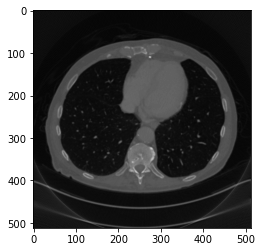

In [26]:
patient,number= 'L506','525'
origin = torch.Tensor(np.load('./2016_mayo_sinogram_img_64/{}_{}_full.npy'.format(patient,number))).unsqueeze(0).unsqueeze(0).to('cuda:0')
origin = get_fbp(origin,n_angles=512)
origin = origin.to('cpu').squeeze(0).squeeze(0).numpy()
plt.imshow(origin,cmap='gray')
plt.show()

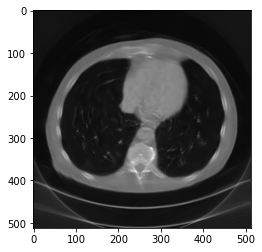

PSNR:35.962520599365234
SSIM:0.9104780554771423
RSME*100:0.02553391642868519


(None, 11.801739037036896)

In [27]:
sinogram = torch.Tensor(np.load('./2016_mayo_sinogram_img_64/L506_525_sparse.npy')).unsqueeze(0).unsqueeze(0).to('cuda:0')
sd_net = sinogram_domain(1,embed_dim=32)
sd_net.load_state_dict(torch.load('./result_model/sinogram_domain_64_2.pkl'),strict=True)
sd_net = sd_net.to('cuda:0')
id_net = image_domain(1,embed_dim=32)
id_net.load_state_dict(torch.load('./result_model/image_domain_64.pkl'),strict=True)
id_net = id_net.to('cuda:0')
sd_net.eval()
id_net.eval()
upsample = nn.Upsample(size=(512,512), mode='bilinear',align_corners=False)
with torch.no_grad():     
    sinogram = upsample(sinogram)
    sinogram = sd_net(sinogram)
    sinogram = get_fbp(sinogram,n_angles=512)
    sinogram = id_net(sinogram)
sinogram = sinogram.to('cpu').squeeze(0).squeeze(0).numpy()
plt.imsave('2016aapm_result/DDPTransformer_64.jpeg', sinogram,cmap='gray')
plt.imshow(sinogram,cmap='gray')
plt.show()
print("PSNR:{}".format(torchPSNR(torch.Tensor(sinogram),torch.Tensor(origin))))
print("SSIM:{}".format(torchSSIM(torch.Tensor(sinogram),torch.Tensor(origin))))
loss = nn.MSELoss()
print("RSME*100:{}".format(100*loss(torch.Tensor(sinogram),torch.Tensor(origin))))
plt.imsave('2016_roi/DDPTransformer_64.jpeg',sinogram[300:300+100,200:200+100],cmap='gray')
residual = origin-sinogram
plt.imsave('2016_residual_image/DDPTransformer_64.jpeg',residual,cmap='gray')
plt.imsave('2016_roi_residual_image/DDPTransformer_64.jpeg',residual[300:300+100,200:200+100],cmap='gray')
plt.show(),rRMSE(sinogram,origin)

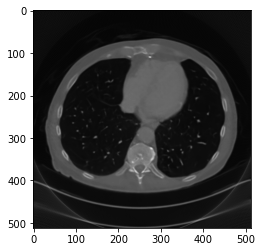

PSNR:43.71204376220703
SSIM:0.9733619093894958
RSME*100:0.004316362552344799


(None, 4.852284491062164)

In [28]:
sinogram = torch.Tensor(np.load('./2016_mayo_sinogram_img_128/L506_525_sparse.npy')).unsqueeze(0).unsqueeze(0).to('cuda:0')
sd_net = sinogram_domain(1,embed_dim=32)
sd_net.load_state_dict(torch.load('./result_model/sinogram_domain_64_2.pkl'),strict=True)
sd_net = sd_net.to('cuda:0')
id_net = image_domain(1,embed_dim=32)
id_net.load_state_dict(torch.load('./result_model/image_domain_64.pkl'),strict=True)
id_net = id_net.to('cuda:0')
sd_net.eval()
id_net.eval()
upsample = nn.Upsample(size=(512,512), mode='bilinear',align_corners=False)
with torch.no_grad():     
    sinogram = upsample(sinogram)
    sinogram = sd_net(sinogram)
    sinogram = get_fbp(sinogram,n_angles=512)
    sinogram = id_net(sinogram)
sinogram = sinogram.to('cpu').squeeze(0).squeeze(0).numpy()
plt.imsave('2016aapm_result/DDPTransformer_128.jpeg', sinogram,cmap='gray')
plt.imshow(sinogram,cmap='gray')
plt.show()
print("PSNR:{}".format(torchPSNR(torch.Tensor(sinogram),torch.Tensor(origin))))
print("SSIM:{}".format(torchSSIM(torch.Tensor(sinogram),torch.Tensor(origin))))
loss = nn.MSELoss()
print("RSME*100:{}".format(100*loss(torch.Tensor(sinogram),torch.Tensor(origin))))
plt.imsave('2016_roi/DDPTransformer_128.jpeg',sinogram[300:300+100,200:200+100],cmap='gray')
residual = origin-sinogram
plt.imsave('2016_residual_image/DDPTransformer_128.jpeg',residual,cmap='gray')
plt.imsave('2016_roi_residual_image/DDPTransformer_128.jpeg',residual[300:300+100,200:200+100],cmap='gray')
plt.show(),rRMSE(sinogram,origin)